In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import os
import sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, match_coord

# Load GAMA DR4

In [2]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

#get rid of stars in GAMA
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

#
gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA


fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.07 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.93 %


# Load DR8 SWEEPS for GAMA footprint only (G12, G15, G09)

In [3]:
#
def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]

# load catalogue
# this is dr8 sweeps in decals with BGSBITS 


dr = 'dr8-south'
#dir where we are going to stored the results
pathdir = '/global/homes/q/qmxp55/DESI/bgs_main/bgs_main_%s_matches/' %(dr)
#if results dir does not exist, create it
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
#get sweeps for GAMA footprint
lsin12 =  get_sweep_whole(patch=gama12(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')
lsin15 =  get_sweep_whole(patch=gama15(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')
lsin09 =  get_sweep_whole(patch=gama09(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')

# merge the SWEEPS in GAMA fileds targets in a single data frame
cat = np.concatenate((lsin12, lsin15, lsin09))


sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_174.0_186.0_-3.0_2.0.npy
Total run time: 0.000215 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.001594 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_129.0_141.0_-2.0_3.0.npy
Total run time: 0.000315 sec


# Match catalogues

In [4]:
#
def match(gama=None, cat=None):
    
    # matching LS8 with gama stars and galaxies
    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    # LS DR8 matched with gama
    dr8_gama = np.zeros_like(cat['RA'], dtype='?') #dr8 that match with gama
    dr8_z = np.full_like(cat['RA'], -1) #z from gama

    dr8_gama[idx2.tolist()] = True
    dr8_z[idx2.tolist()] = gama['Z'][idx1]
    
    return dr8_gama, dr8_z


In [5]:
#
dr8_gama, dr8_z = match(gama, cat)
#get BGS targets
bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #| (L2) #adding the LSLGA galaxies
print('fraction of bgs in %s within GAMA: %i / %i' %(dr, np.sum(bgs), len(cat)))


Doubly matched objects = 2
Final matched objects = 181919
fraction of bgs in dr8-south within GAMA: 256973 / 14545644


mean: 	 0.2243 (all) 	 0.2155 (bright) 	 0.2653 (faint)


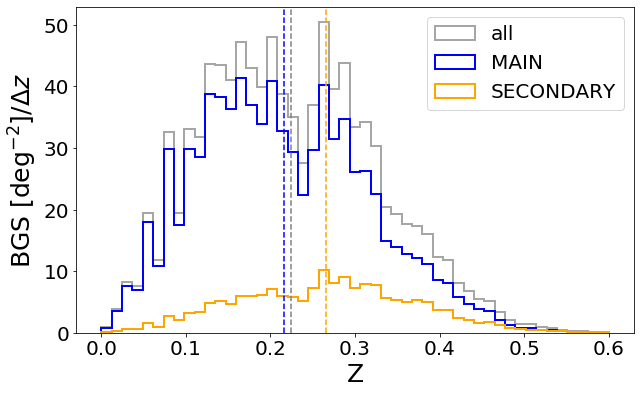

In [6]:
#
fig = plt.figure(figsize=(10,6))

N = np.sum((dr8_gama) & (bgs))
cumu = False
Ared = 175

mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (bgs)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] < 19.5) & (bgs)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.) & (bgs)
bins = np.linspace(0,0.6,50)

#plt.title(r'BGS cross-matched with GAMA DR3', size=18)
plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='blue', label='MAIN')
plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='orange', label='SECONDARY')

print('mean: \t %.4f (all) \t %.4f (bright) \t %.4f (faint)' %(
    np.mean(dr8_z[mask]), np.mean(dr8_z[maskB]), np.mean(dr8_z[maskF])
    ))
plt.axvline(np.mean(dr8_z[mask]), ls='--', c='gray')
plt.axvline(np.mean(dr8_z[maskB]), ls='--', c='blue')
plt.axvline(np.mean(dr8_z[maskF]), ls='--', c='orange')

#plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
#plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=25)
plt.ylabel(r'BGS [deg$^{-2}$]/$\Delta z$', size=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

file = pathdir+'bgs_nz'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)
